## GRAD - CAM ANALYSIS
Trying to figure out why model has lower performance in normal images vs portable ones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import torchvision.transforms as transforms

from PIL import Image

import random
import torchio as tio
from utils.spatial_transforms import ToTensor

from IPython.display import display

import json
from parse_args import create_exerpiment_setting
from utils import basics
import torch.nn.functional as F

from mynotebooks.results_utils import preprocess_mimic_data



## Get initial predictions

In [6]:
path_to_preds = '/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/MIMIC_CXR/Race/cusResNet18/baseline/pred.csv'
path_to_test_csv = '/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/mimic-cxr/splits/test.csv'
all_test_df = preprocess_mimic_data(path_to_preds, path_to_test_csv)
all_test_df = all_test_df.drop(columns=['Unnamed: 0'])

In [7]:
# use this to find index of images you are interested in
all_test_df[all_test_df['TN']==1].head(5)

,path,patient_cat,subject_id,study_id,image,patient_study_id,Race_multi,Sex,anchor_age,Race,...,binary_label,insurance,marital_status,pred,FN,FP,TN,TP,PerformedProcedureStepDescription,Race_cat
0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,a4881c3f-2cbb518b-5ae285c0-2eb7dce3-8581dd5a.jpg,p16187827s56495550,WHITE,M,80,White,...,1.0,Medicare,MARRIED,1.0,0,0,1,0,CHEST (PA AND LAT),White
1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16187827,56495550,ef942ffb-b4ae474f-78a10926-7968938b-a27467d6.jpg,p16187827s56495550,WHITE,M,80,White,...,1.0,Medicare,MARRIED,1.0,0,0,1,0,CHEST (PA AND LAT),White
2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,694ce382-1f0b42e0-eaf0e2cb-b7bf3429-2b7582f6.jpg,p16160632s59201056,WHITE,F,54,White,...,1.0,Medicare,SINGLE,1.0,0,0,1,0,CHEST (PA AND LAT),White
3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16160632,59201056,048ee716-f88d3a1d-4e18e4c3-c02b1bc8-37fe382e.jpg,p16160632s59201056,WHITE,F,54,White,...,1.0,Medicare,SINGLE,1.0,0,0,1,0,CHEST (PA AND LAT),White
14,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16619211,57684539,0ce3037f-5d0a80f1-9e165cfb-301355eb-5e225c0e.jpg,p16619211s57684539,WHITE,F,51,White,...,1.0,Other,MARRIED,1.0,0,0,1,0,CHEST (PA AND LAT),White


## Get model and set up GRADCAM

In [8]:
# opt file I have saved from baseline run
with open('opt.json', 'r') as f:
    opt = json.load(f)

# can change model path    
opt['resume_path']='/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/MIMIC_CXR/Race/cusResNet18/baseline/'
opt['random_seed']=6

opt,wandb= create_exerpiment_setting(opt,do_wandb=False)

model = basics.get_model(opt, wandb)

test_model = model.network

class ModelOutputWrapper(torch.nn.Module):
    def __init__(self, test_model):
        super(ModelOutputWrapper, self).__init__()
        self.test_model = test_model

    def forward(self, x):
        outputs,_ = self.test_model.forward(x)
        sig_outputs = F.sigmoid(outputs).flatten().cpu().data.numpy().tolist()
        return outputs

wrapped_model = ModelOutputWrapper(test_model) # wrap model so it only returns outputs and not features

run hash (first 10 digits):  6044dffc5f


pickle_train_path /gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/mimic-cxr/pkls/train_images.pkl
loaded dataset  MIMIC_CXR


In [4]:
model.test()

Testing, loaded model from  your_path/fariness_data/model_records/MIMIC_CXR/Age/cusResNet18/baseline/age_baseline_notpretrain/6_best.pth
Finish testing, testing performance: 
{'Test Overall AUC': 0.8371279980279533, 'Test auc-group_0': 0.840766454142788, 'Test auc-group_1': 0.8062370083871118, 'Test Overall Acc': 0.7660311386726482, 'Test acc-group_0': 0.7576363776256059, 'Test acc-group_1': 0.7723309659911081, 'Test DP': 0.7187312605546804, 'Test EqOpp1': 0.8425308809556129, 'Test EqOpp0': 0.774610553203357, 'Test EqOdd': 0.8085707170794849, 'Test EqOdd_0.5': 0.7765756318774313, 'Test EqOdd_specificity_0.8': 0.7935081976171169, 'Test EqOdd_sensitivity_0.8': 0.8214605377262076, 'Test Overall ECE': 0.019820069622533253, 'Test Overall BCE': 0.4721613733809674, 'Test tpr_at_tnr_0': array(0.72829502), 'Test fnr_at_thres-group_0': 0.2015875640813627, 'Test fpr_at_thres-group_0': 0.2519424460431655, 'Test recall_at_thres-group_0': 0.7984124359186373, 'Test specificity_at_thres-group_0': 0.74

,Test Overall AUC,Test auc-group_0,Test auc-group_1,Test Overall Acc,Test acc-group_0,Test acc-group_1,Test DP,Test EqOpp1,Test EqOpp0,Test EqOdd,...,Test ECE-group_1,Test BCE-group_1,Test worst_auc,Test worst_group,Test Overall FPR,Test Overall FNR,Test FPR-group_0,Test FPR-group_1,Test FNR-group_0,Test FNR-group_1
0,0.837128,0.840766,0.806237,0.766031,0.757636,0.772331,0.718731,0.842531,0.774611,0.808571,...,0.017642,0.455262,0.806237,auc-group_1,0.236299,0.229664,0.3381,0.1807,0.1323,0.3577


### Code to run inference - currently ouputting strange results

In [5]:
# compare with what you find without the wrapped model
for i in range(4):
    test_image_pkls = '/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/mimic-cxr/pkls/test_images.pkl'

    import pickle
    with open(test_image_pkls, 'rb') as f:
        test_images = pickle.load(f)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    transform_test = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

    img = Image.fromarray(test_images[i]).convert('RGB') # can view this image just by runnig img
    t_img = transform_test(img)
    t_img = t_img.unsqueeze(0).cuda()

    outputs, b = model.network.forward(t_img)
    print(outputs)
    print(F.sigmoid(outputs).flatten().cpu().data.numpy().tolist())

tensor([[-0.5562]], device='cuda:0', grad_fn=<AddmmBackward0>)
[0.3644157350063324]
tensor([[0.6810]], device='cuda:0', grad_fn=<AddmmBackward0>)
[0.6639717221260071]
tensor([[-0.1023]], device='cuda:0', grad_fn=<AddmmBackward0>)
[0.47443699836730957]
tensor([[-0.4542]], device='cuda:0', grad_fn=<AddmmBackward0>)
[0.3883514702320099]


In [5]:
def visualise_gradcam(image_index, target_layers):
    i = image_index

    test_image_pkls = '/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/mimic-cxr/pkls/test_images.pkl'

    import pickle
    with open(test_image_pkls, 'rb') as f:
        test_images = pickle.load(f)

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    transform_test = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

    img = Image.fromarray(test_images[i]).convert('RGB') # can view this image just by runnig img
    t_img = transform_test(img)
    t_img = t_img.unsqueeze(0).cuda()

    # array img to use for viewing gradcam
    array_img = np.array(img)
    array_img = array_img / 255 # normalise so all values are btwn 0 and 1
    array_img = array_img[16:240, 16:240, :]

    with GradCAM(model=wrapped_model,
                    target_layers=target_layers) as cam: # think i can specify what target class I want to consider
            grayscale_cam = cam(input_tensor=t_img)[0, :]
            cam_image = show_cam_on_image(array_img, grayscale_cam, use_rgb=True)

    img = Image.fromarray(cam_image)
    display(img)

    return array_img, grayscale_cam

In [ ]:
model.network

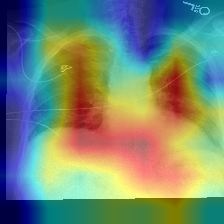

In [12]:
target_layers = [list(model.network.body.layer4.children())[1].conv2] #list(model.network.body.layer4.children())[1].conv2] # can change to any layer you want
array_img, grayscale_cam = visualise_gradcam(0, target_layers)

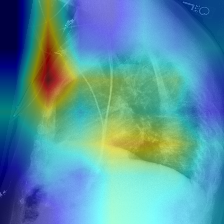

In [14]:
target_layers = [list(model.network.body.layer4.children())[1].conv2] #list(model.network.body.layer4.children())[1].conv2] # can change to any layer you want
array_img, grayscale_cam = visualise_gradcam(1, target_layers)

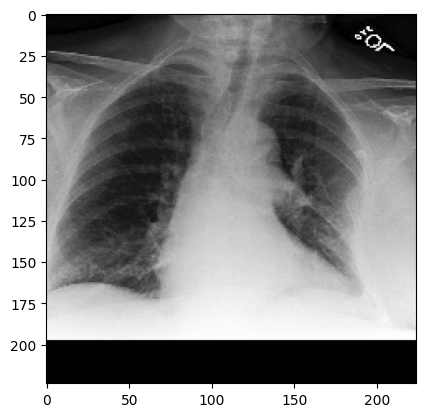

In [6]:
plt.imshow(array_img)